In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import astropy.units as u
import astropy.constants as c

def rcparams_format(dic):
    dic['text.usetex'] = True
    dic['font.family'] = 'sans-serif'
    dic['font.sans-serif'] = ['Ariel']
    dic['font.size'] = 25
    dic['xtick.labelsize'] = 25
    dic['ytick.labelsize'] = 25
    dic['xtick.major.size'] = 6
    dic['ytick.major.size'] = 6
    dic['xtick.major.width'] = 1.6
    dic['ytick.major.width'] = 1.6
    dic['xtick.minor.size'] = 3
    dic['ytick.minor.size'] = 3
rcparams_format(mpl.rcParams)

## SEDs for SN 2004et and SN 2017eaw

In [2]:
# Flux [muJy] - Table 1 in Shahbandeh+2023
Fnu_04et = np.array([15.96, 122.63, 279.68, 456.39, 727.80, 1037.30, 1238.45, 1804.75])
Fnu_unc_04et = np.array([0.49, 1.51, 3.60, 4.36, 5.85, 6.42, 7.58, 21.60])
Fnu_17eaw = np.array([6.39, 58.12, 51.17, 43.30, 63.26, 117.00, 128.20, 102.47])
Fnu_unc_17eaw = np.array([0.29, 0.79, 1.25, 0.58, 0.69, 1.28, 1.61, 6.08])

## Meta data

Text(0.5, 0, '$\\lambda\\ [\\mu\\mathrm{m}]$')

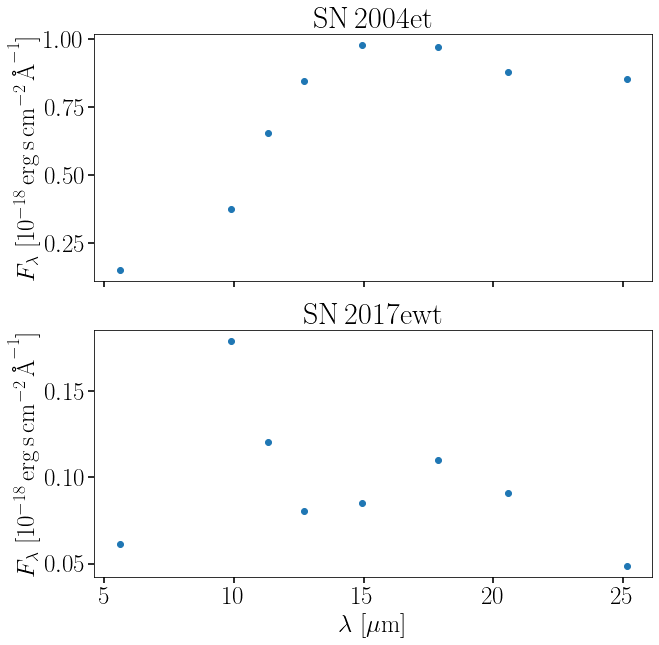

In [3]:
# Distance
D = 7.12  # Mpc
# Heliocentric redshift
z = 0.00013
# Filters
flts = glob.glob('JWST_filters/*dat')
flts.sort()
# Effective wavelengths
wvs_eff = np.array([55870.54, 98792.57, 112960.72, 127060.62,
                  149256.55, 178732.78, 205607.10, 251520.10])
dlam_dnu = wvs_eff / (2.99792458e10 / (wvs_eff * 1e-8)) # Ang/Hz
Flam_04et = Fnu_04et / dlam_dnu * 1e-6 * 1e-23
Flam_unc_04et = Fnu_unc_04et / dlam_dnu * 1e-6 * 1e-23
Flam_17eaw = Fnu_17eaw / dlam_dnu * 1e-6 * 1e-23
Flam_unc_17eaw = Fnu_unc_17eaw / dlam_dnu * 1e-6 * 1e-23

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax[0].errorbar(wvs_eff / 1e4, Flam_04et / 1e-18, yerr=Flam_unc_04et, fmt='o')
ax[1].errorbar(wvs_eff / 1e4, Flam_17eaw / 1e-18, yerr=Flam_unc_17eaw, fmt='o')
ax[0].set_title(r'$\mathrm{SN\,2004et}$')
ax[1].set_title(r'$\mathrm{SN\,2017ewt}$')
ax[0].set_ylabel('$F_\lambda\ [10^{-18}\,\mathrm{erg}\,\mathrm{s}\,\mathrm{cm}^{-2}\,\mathrm{\AA}^{-1}]$')
ax[1].set_ylabel('$F_\lambda\ [10^{-18}\,\mathrm{erg}\,\mathrm{s}\,\mathrm{cm}^{-2}\,\mathrm{\AA}^{-1}]$')
ax[1].set_xlabel('$\lambda\ [\mu\mathrm{m}]$')

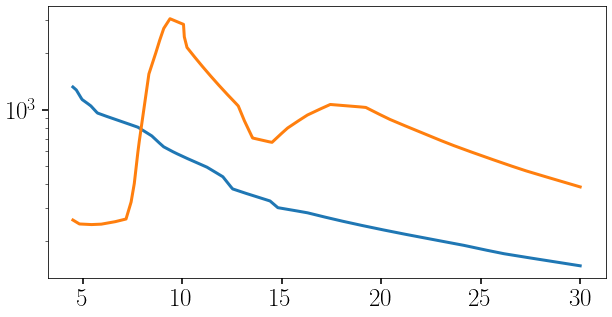

In [134]:
wv_grid = np.linspace(45000, 300000, 10000)

kappa_C_Sarangi = np.loadtxt('C.csv', delimiter=',')
kappa_Si_Sarangi = np.loadtxt('Si.csv', delimiter=',')

from scipy.interpolate import interp1d

kappa_C = 10**interp1d(x=kappa_C_Sarangi[:, 0], y=kappa_C_Sarangi[:, 1])(np.log10(wv_grid/1e4))
kappa_Si = 10**interp1d(x=kappa_Si_Sarangi[:, 0], y=kappa_Si_Sarangi[:, 1])(np.log10(wv_grid/1e4))

plt.figure(figsize=(10, 5))
plt.plot(wv_grid/1e4, kappa_C, linewidth=3)
plt.plot(wv_grid/1e4, kappa_Si, linewidth=3)
plt.yscale('log')

## Synthetic photometry

In [8]:
def spec_to_flux(spec, flt):
    '''
    get synthetic photometry from SED
    '''
    wv, fl = spec

    wv_flt, tra_flt = flt[:, 0], flt[:, 1]  # filter
    
    # if (wv_flt[9] < wv[0]) or (wv_flt[-10] > wv[-1]):
    #         return np.nan, np.nan
    tra_interp = np.interp(x=wv, xp=wv_flt, fp=tra_flt)
    tra_interp[(wv < wv_flt[0]) | (wv > wv_flt[-1])] = 0
    
    # effective bandwidth
    dlambda = np.diff(wv)
    width = (dlambda * tra_interp[1:] * wv[1:]).sum()
    # convolution
    weight = tra_interp[1:] * wv[1:] / width * dlambda
    flux = (fl[1:] * weight).sum()  # erg cm-2 s-1 AA-1
    return flux

In [9]:
def B_lam(lam, T):
    hc = (1 * c.h * c.c**2 / u.AA**5).to('erg*cm**-2*s**-1*AA**-1').value
    hc_k = (1 * c.h * c.c / u.AA / c.k_B / u.Kelvin).cgs.value
    return 2 * hc / lam**5 / (np.exp(hc_k / lam / T) - 1)


## Models

In [169]:
import pymc as pm
import arviz as az
import corner

In [160]:
def single_T_model(kappa, Flam, Flam_unc):
    with pm.Model() as single_T:
        log_T = pm.Uniform('log_T', 1, 4)
        T = pm.Deterministic('T', 10**log_T)
        log_Mobs = pm.Uniform('log_Mobs', -4, 1)
        Mobs = pm.Deterministic('Mobs', 10**log_Mobs)

        D = pm.Normal('D', 7.12, 0.1)
        Msun = (1*u.Msun/u.g).cgs.value
        Mpc = (1*u.Mpc/u.cm).cgs.value
        F = pm.Deterministic('F', B_lam(wv_grid, T) *
                             (Mobs * Msun) * kappa / (D * Mpc)**2)
        flams = []
        for k in range(len(Flam)):
            flt = np.loadtxt(flts[k])
            flams.append(pm.Deterministic(
                f'flam_{k}', spec_to_flux(spec=[wv_grid, F], flt=flt)))
        pm.Normal('obs', flams, Flam_unc, observed=Flam)

    with single_T:
        trace = pm.sample(return_inferencedata=True)
    return trace


def double_T_model(kappa, Flam, Flam_unc, T_thres=500, T1_mu=-1, T1_sig=-1, T2_mu=-1, T2_sig=-1):
    with pm.Model() as double_T:
        if T1_mu < 0:
            log_T1 = pm.Uniform('log_T1', 1, np.log10(T_thres))
            T1 = pm.Deterministic('T1', 10**log_T1)
        else:
            T1 = pm.Normal('T1', T1_mu, T1_sig)
        if T2_mu < 0:
            log_T2 = pm.Uniform('log_T2', np.log10(T_thres), 4)
            T2 = pm.Deterministic('T2', 10**log_T2)
        else:
            T2 = pm.Normal('T2', T2_mu, T2_sig)

        log_Mobs1 = pm.Uniform('log_Mobs1', -5, 1)
        Mobs1 = pm.Deterministic('Mobs1', 10**log_Mobs1)
        log_Mobs2 = pm.Uniform('log_Mobs2', -8, 1)
        Mobs2 = pm.Deterministic('Mobs2', 10**log_Mobs2)
        Mobs = pm.Deterministic('Mobs', Mobs1 + Mobs2)

        D = pm.Normal('D', 7.12, 0.1)
        Msun = (1*u.Msun/u.g).cgs.value
        Mpc = (1*u.Mpc/u.cm).cgs.value
        F = pm.Deterministic('F', (B_lam(wv_grid, T1) * Mobs1 +
                             B_lam(wv_grid, T2) * Mobs2) * Msun * kappa / (D * Mpc)**2)
        flams = []
        for k in range(len(Flam)):
            flt = np.loadtxt(flts[k])
            flams.append(pm.Deterministic(
                f'flam_{k}', spec_to_flux(spec=[wv_grid, F], flt=flt)))
        pm.Normal('obs', flams, Flam_unc, observed=Flam)

    with double_T:
        trace = pm.sample(return_inferencedata=True)
    return trace


In [152]:
def plot_model(trace, Flam, Flam_unc):
    summary = az.summary(trace, hdi_prob=0.68, var_names=[
                         f'flam_{k}' for k in range(len(wvs_eff))], round_to=25)
    plt.figure(figsize=(10, 6))
    plt.plot(
        wv_grid/1e4, trace.posterior['F'].values.reshape(4000, 10000)[::10].T/1e-18, color='0.3', alpha=.1, linewidth=.3)
    plt.errorbar(
        wvs_eff/1e4,
        summary['mean']/1e-18,
        yerr=np.array([summary['hdi_84%'] - summary['mean'],
                       summary['mean'] - summary['hdi_16%']])/1e-18,
        color='k', fmt='v', label=r'$\mathrm{Model}$', ms=10)
    for k in range(len(wvs_eff)):
        flt = np.loadtxt(flts[k])
        plt.plot(flt[:, 0]/1e4, flt[:, 1] * Flam.max()/1e-18, color='0.8')
    plt.errorbar(wvs_eff/1e4, Flam/1e-18, yerr=Flam_unc/1e-18,
                 label=r'$\mathrm{Obs}$', color='crimson', fmt='o', ms=10)
    plt.legend(prop={'size': 20})

    plt.ylabel(
        '$F_\lambda\ [10^{-18}\,\mathrm{erg}\,\mathrm{s}\,\mathrm{cm}^{-2}\,\mathrm{\AA}^{-1}]$')
    plt.xlabel('$\lambda\ [\mu\mathrm{m}]$')


## SN 2004et

### Single temperature component

#### C

In [ ]:
trace_04et_C_s = single_T_model(kappa_C, Flam_04et, Flam_unc_04et)
summary_04et_C_s = az.summary(trace_04et_C_s, hdi_prob=0.68, var_names=['D', 'T', 'Mobs'])

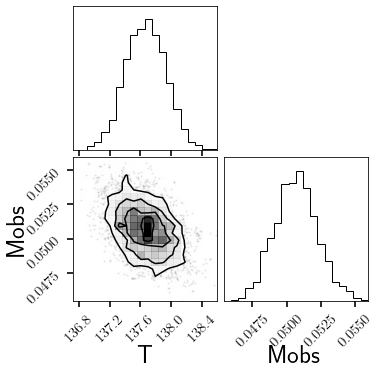

In [177]:
fig = corner.corner(trace_04et_C_s, var_names=['T', 'Mobs'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

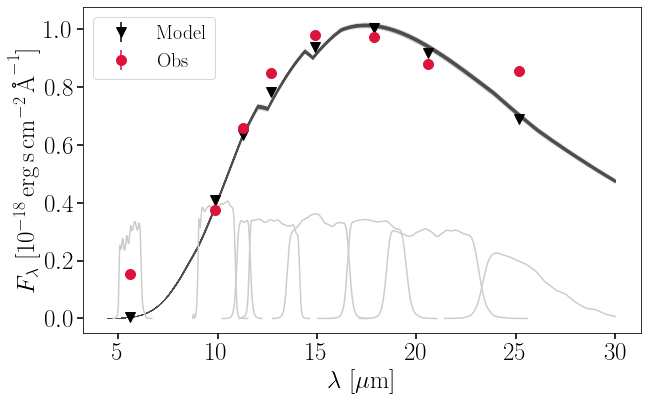

In [145]:
plot_model(trace_04et_C_s, Flam_04et, Flam_unc_04et)

#### Si

In [136]:
trace_04et_Si_s = single_T_model(kappa_Si, Flam_04et, Flam_unc_04et)
summary_04et_Si_s = az.summary(trace_04et_Si_s, hdi_prob=0.68, var_names=['D', 'T', 'Mobs'])
summary_04et_Si_s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.121,0.098,7.012,7.207,0.003,0.002,1252.0,1425.0,1.0
T,138.887,0.236,138.672,139.139,0.006,0.004,1773.0,1658.0,1.0
Mobs,0.013,0.000,0.012,0.013,0.000,0.000,1126.0,1243.0,1.0


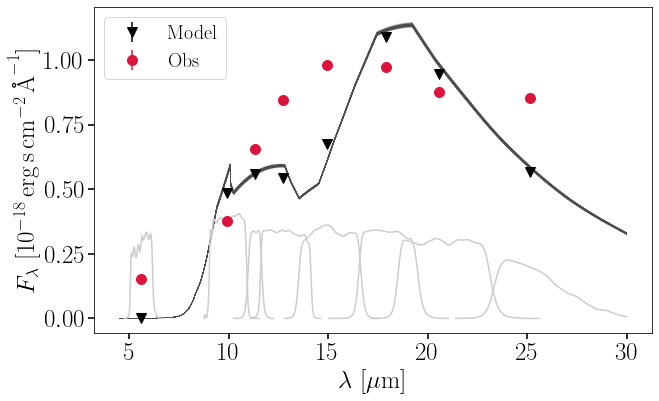

In [146]:
plot_model(trace_04et_Si_s, Flam_04et, Flam_unc_04et)

### Double temperature components

In [181]:
trace_04et_C_d = double_T_model(kappa_C, Flam_04et, Flam_unc_04et, T2_mu=1000, T2_sig=200)
summary_04et_C_d = az.summary(trace_04et_C_d, hdi_prob=0.68, var_names=['D', 'T1', 'T2', 'Mobs'])

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [182]:
summary_04et_C_d

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.120,0.100,7.029,7.229,0.002,0.002,1703.0,1671.0,1.0
T1,136.814,0.264,136.568,137.092,0.006,0.004,2190.0,1994.0,1.0
T2,1292.428,164.420,1131.607,1455.483,4.605,3.257,1245.0,1040.0,1.0
Mobs,0.053,0.002,0.051,0.054,0.000,0.000,1618.0,1688.0,1.0


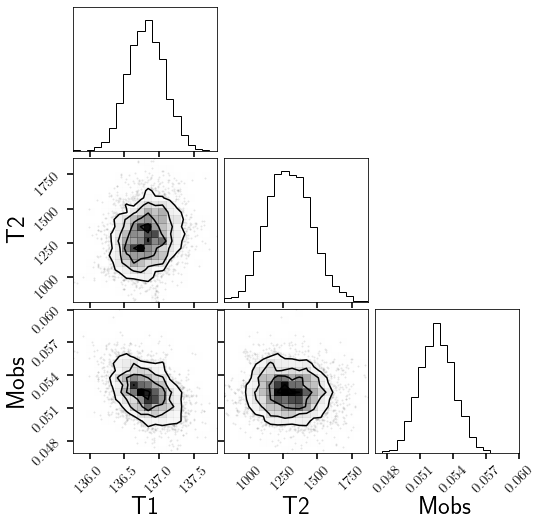

In [183]:
fig = corner.corner(trace_04et_C_d, var_names=['T1', 'T2', 'Mobs'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

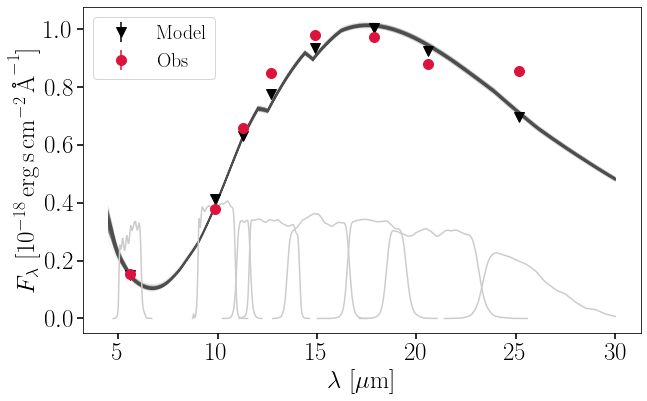

In [184]:
plot_model(trace_04et_C_d, Flam_04et, Flam_unc_04et)

## SN 2017eaw

### Single temperature component

In [148]:
trace_17eaw_Si_s = single_T_model(kappa_Si, Flam_17eaw, Flam_unc_17eaw)
summary_17eaw_Si_s = az.summary(trace_17eaw_Si_s, hdi_prob=0.68, var_names=['D', 'T', 'Mobs'], round_to=5)
summary_17eaw_Si_s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
The acceptance probability does not match the target. It is 0.8801, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.11757,0.10048,7.02338,7.21816,0.00255,0.00181,1555.16797,1461.52876,1.00124
T,182.16616,0.86046,181.26108,182.99453,0.02255,0.01595,1450.29492,1644.61208,1.00229
Mobs,0.00033,0.00001,0.00031,0.00034,0.00000,0.00000,1325.40704,1260.13682,1.00228


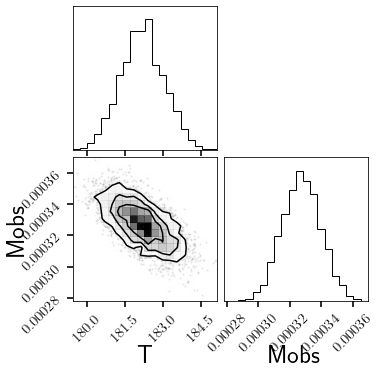

In [185]:
fig = corner.corner(trace_17eaw_Si_s, var_names=['T', 'Mobs'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

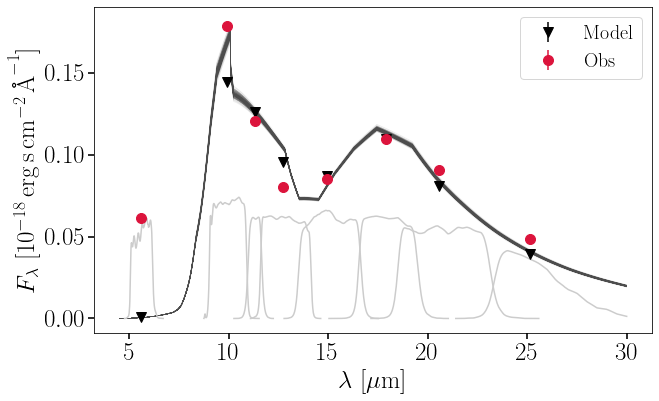

In [153]:
plot_model(trace_17eaw_Si_s, Flam_17eaw, Flam_unc_17eaw)

### Double temperature components

In [161]:
trace_17eaw_Si_d = double_T_model(kappa_Si, Flam_17eaw, Flam_unc_17eaw, T_thres=800)
summary_17eaw_Si_d = az.summary(trace_17eaw_Si_d, hdi_prob=0.68, var_names=['D', 'T1', 'T2', 'Mobs'], round_to=5)
summary_17eaw_Si_d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.11894,0.09989,7.02762,7.22153,0.00244,0.00173,1663.44457,1796.02412,1.00137
T1,153.00398,1.54813,151.24598,154.26260,0.04659,0.03296,1112.07607,1383.46818,1.00183
T2,1557.00781,227.41474,1295.51878,1695.76782,7.29787,5.28244,1081.05543,982.41547,1.00165
Mobs,0.00075,0.00004,0.00070,0.00079,0.00000,0.00000,1121.39539,1325.38955,1.00255


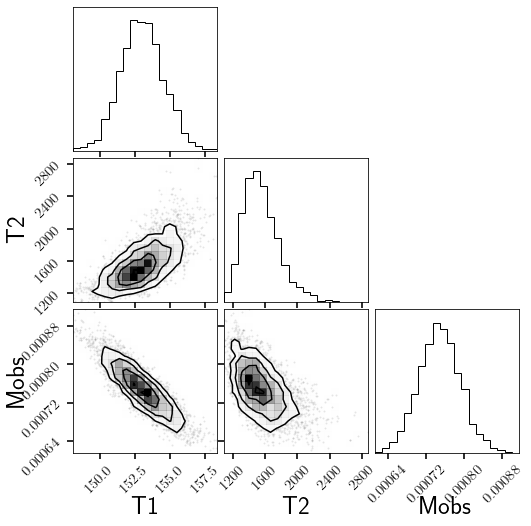

In [180]:
fig = corner.corner(trace_17eaw_Si_d, var_names=['T1', 'T2', 'Mobs'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

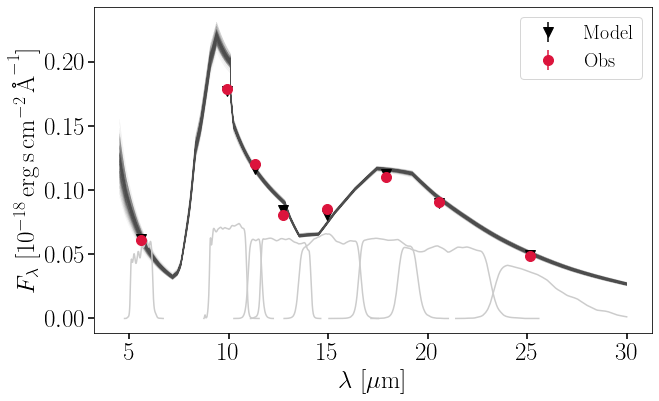

In [162]:
plot_model(trace_17eaw_Si_d, Flam_17eaw, Flam_unc_17eaw)